# SVB surface test script

This script demonstrates SVB running 'on the surface' to infer the parameters of a single exponential decay signal model. 

Voxel-wise data is generated with a given amplitude, decay rate and noise SD. Each voxel in the volume is an independent time series of samples. Although they all share the same underlying signal parameters, the additive zero-mean (aka white) noise present in each one will be different. 

A spherical surface is then generated to intersect the voxel grid (note that many voxels will not intersect the surface and are therefore discarded). Multiple surface vertices may be present in each voxel, leading to an under-determined system. The SVB framework is used to infer the signal parameters at each vertex *on the surface* using the data generated in *volume space*. The process is run both with and without the spatial prior to illustrate how this is helpful in an under-determined system. 

In [1]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
import toblerone as tob 
import regtricks as rt
import trimesh
from svb.main import run
import pyvista as pv 
from pyvista import PlotterITK

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

# To make tests repeatable
tf.set_random_seed(1)
np.random.seed(1)

Instructions for updating:
non-resource variables are not supported in the long term


Generate a cubic voxel grid of data. The model parameters for the exponential case are amplitude and decay rate, and the noise is zero-mean with a given SD (aka white noise). Multiple samples are taken from the exponential curve to produce a 4D dataset (X,Y,Z,T)

In [2]:
num_times = 200
sq_len = 10 
vox_size = 2
true_params = {
    "amp1" : 10.0, # the true amplitude of the model
    "r1" : 3.0,    # the true decay rate
    "noise_sd" : 0.5, # zero-mean Gaussian noise with SD
}
true_var = true_params["noise_sd"]**2
dt = 5.0/(true_params["r1"] * num_times)

shape = 3 * [sq_len] + [num_times]
data = np.zeros(shape)
for t_idx in range(num_times):
    t = t_idx*dt
    data[..., t_idx] = true_params["amp1"] * np.exp(-true_params["r1"]*t)
noise = np.random.normal(0, true_params["noise_sd"], size=shape)
print('Data shape', data.shape)

Data shape (10, 10, 10, 200)


Create a reference voxel grid for the data 


In [3]:
ref_spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), 3 * [sq_len], 3 * [vox_size])
bounding_box = np.array([ref_spc.bbox_origin, ref_spc.bbox_origin + ref_spc.fov_size])
bounding_box = np.meshgrid(*[
    np.linspace(s,e,2) for (s,e) in bounding_box.T
])
ref_spc

ImageSpace with properties:
size:          [  10.000   10.000   10.000], 
voxel size:    [   2.000    2.000    2.000], 
field of view: [  20.000   20.000   20.000],
vox2world:     [   2.000    0.000    0.000    1.000]
               [   0.000    2.000    0.000    1.000]
               [   0.000    0.000    2.000    1.000]
               [   0.000    0.000    0.000    1.000]
loaded from: (no direct file counterpart)

Generate a spherical cortex, with radius slightly smaller than 1/2 the FoV of the reference space. `in_surf` and `out_surf` represent the white and pial surfaces; `mid_surf` is the surface on which inference will be performed. Calculate the mean vertex spacing on the surface: this has an important interplay with `ak`, the weight that is given to the spatial regularisation term (Lapalcian). 

In [6]:
ctx_thickness = 1
out_r = ((sq_len * vox_size) - 1) / 2
in_r = out_r - ctx_thickness
mid_r = out_r - (ctx_thickness / 2)
mesh = trimesh.creation.icosphere(2, 1)
shift = 1.5 * (np.random.rand(*mesh.vertices.shape) - 0.5)
orig = (ref_spc.fov_size / 2)

out_surf = tob.Surface.manual((out_r * mesh.vertices) + orig + shift, mesh.faces)
in_surf = tob.Surface.manual((in_r * mesh.vertices) + orig + shift, mesh.faces)
mid_surf = tob.Surface.manual((mid_r * mesh.vertices) + orig + shift, mesh.faces)

print(mid_surf)
mid_edges = mid_surf.edges()
vertex_dist = np.linalg.norm(mid_edges, axis=-1).reshape(-1,3).mean()
print("Mean vertex spacing on midsurface {:.2f}mm".format(vertex_dist))

Surface with 162 points and 320 triangles. 
min (X,Y,Z):  [0.52913207 0.8134389  0.70790213]
mean (X,Y,Z): [10.018255  9.974704 10.000273]
max (X,Y,Z):  [19.383953 19.171171 19.181038]

Mean vertex spacing on midsurface 2.85mm


Plot the cortical outer surface within the reference voxel grid to check it is fully contained. 

In [7]:
plot = PlotterITK()
v = pv.StructuredGrid(*bounding_box)
plot.add_mesh(v, opacity=0.3)
plot.add_mesh(out_surf.to_polydata(), color='tan')
plot.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Initialise the projector that will be used to map data from the surface into the volume. This incorporates PV weighting, so the ground truth data that we provide to the SVB fit must include PV effects. 

In [8]:
hemi = tob.Hemisphere.manual(in_surf, out_surf, 'L')
projector = tob.projection.Projector(hemi, ref_spc)
projector.surf2vol_matrix().shape

Initialising projector (will take some time)


L cortex in: 100%|########## 00:08 | 00:00
L cortex out: 100%|########## 00:11 | 00:00


(1000, 162)

Generate a mask of voxels that do not intersect the cortex. Calculate the mean number of vertices per voxel for those that do intersect. A cortical surface at 32k resolution in a voxel grid of ~3mm iso has around 10 vertices per voxel. 

In [9]:
vertices_per_voxel = (projector.surf2vol_matrix() > 0).sum(1).A.flatten()
vol_mask = (vertices_per_voxel > 0)
surf2vol_weights = projector.surf2vol_matrix()[vol_mask,:]
print("Mean vertices per voxel:", (surf2vol_weights > 0).sum(1).mean())

Mean vertices per voxel: 6.148225469728601


Apply the PV weighting to the data and add noise *afterwards*. The assumption is that noise is a random process that is not related to the amount of tissue present in a voxel. Plot the PV map and the final simulated data. 

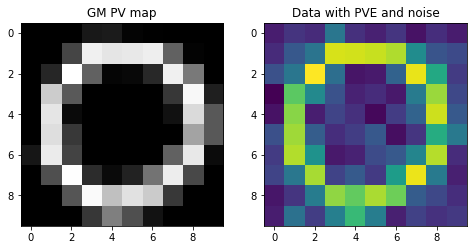

In [10]:
pvs = projector.flat_pvs()
data_pv = (data * pvs[:,0].reshape(ref_spc.size)[...,None]) + noise
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('GM PV map')
plt.imshow(pvs.reshape(*ref_spc.size, -1)[:,:,2,0], cmap='gist_gray')
plt.subplot(1,2,2)
plt.title('Data with PVE and noise')
plt.imshow(data_pv[:,:,2,0])
plt.show()

Plot the surface to volume projection matrix

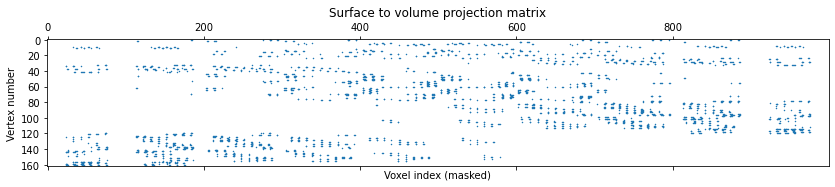

In [11]:
plt.figure(figsize=(14,5))
plt.spy(projector.surf2vol_matrix().T, markersize=0.5)
plt.title('Surface to volume projection matrix')
plt.ylabel('Vertex number')
plt.xlabel('Voxel index (masked)')
plt.show()

Perform the SVB inference process. 

The aim of VB is to infer the posterior distribution on the model parameters of interest (CBF, ATT etc), conditioned on the data that we have obtained and our prior knowledge. In simpler terms: given the data, and given our prior knowledge of the brain, what are the parameter estimates (means) and associated uncertainties (variances) across the brain?

Analytically, deriving the true posterior would involve intractable integrals, so the approach adopted in VB is to find an approximation $q$ to the true posterior $p$. We start with a general form of approximating posterior $q$ and update its properties (mean, variance) until it best approximates the true posterior. 

For each model parameter, we infer a posterior distribution. So, for CBF and ATT, we have two posterior distributions to find. For simplicity, we will assume a normal distribution for each (and a 2-dimensional multivariate normal MVN for the joint posterior). 

Each posterior distribution is described by a mean and a variance. These are the _hyperparameters_ of the inference process. Note that for each model parameter, we have _two hyperparameters_ (in the MVN case). 

We would like to find the hyperparameters that produce a distribution on each model parameter that best matches the true posterior. This is the objective of SVB: find the hyperparameters that best approximate reality. Note that this entire process is performed in each voxel. We would like to estimate parameters in _each voxel_, so we therefore have posteriors in _each_ voxel, and therefore we need hyperparameters to approximate the posteriors in _each_ voxel. 

SVB does this by performing an optimisation on the hyperparameter estimates. The objective/cost function is a similarity metric between the true posterior $p$ and approximating posterior $q$ called the KL divergence. Mathematically, this is equivalent to the free energy between the two distributions, and this in turn may be expressed as the difference between the log-likelihood and the KL divergence between $q$ and the prior $p_0$. Mathematically: 

min (KL divergence $(p,q)$) => max (free energy $(p,q)$) = max (Log-likelihood - KL divergence $(p_0,q)$)

**Some super important points to note here:**
 - Although the objective is to minimise the KL divergence, we don't ever calculate it directly. This is because to do so would require the true posterior $p$, which we don't have
 - Instead, we aim to maximise the free energy, which is mathematically equivalent 
 - This approach only requires the log likelihood (which we have from our forward model) and the KL divergence between the approximating posterior $q$ and our priors $p_0$. We have all of these things! 

The first term in the free energy expression drives the optimisation towards parameter values that explain the data (ie, when you put them into the forward model, you get an output that matches your observed data). The second term encourages an approximate posterior distribution that is close to the prior.

### How to perform the optimisation?

Note the following is very much black box from the point of view of our problem: tensorflow takes care of the details. 

SVB uses stochastic gradient descent to find the optimum hyperparameter values. Any set of hyperparameters (a point in hyperparameter space) is associated with a set of approximate posterior distributions for which we can calculate the cost - KL divergence - with respect to the true posterior. We can also calculate the _gradient_ in cost at each point, and this tells us in which direction we should update the hyperparameters to best reduce cost.  

Conceptually, the optimisation loop proceeds as follows. Recall that this is happening *in every voxel*
1. Using the current set of hyperparameter estimates, produce the approximate posterior distributions 
2. Calculate the gradient in cost (KL divergence between these and the true posterior). This gives the direction of steepest ascent. 
3. Update the hyperparameter estimates by a small step in the opposite direction, and return to step 1. 

All the hard shit: 
The first thing to note is that calculation of the KL divergence aka free energy as formulated above *almost certainly involves intractable integrals* for any non-trivial problem. This is because both terms involve expectations over $q$, ie, integrals over all hyperparameter space (recall an expectation of a random variable requires integrating over all infinity). 

We can get around by sampling (which puts us into the broad category of MCMC methods). In particular, we can use the fact that an expectation over a distribution can be numerically approximated by averaging over a number of samples drawn from the same distribution. So, instead of calculating KL divergence analytically, via integration, we will take a number of samples and numerically approximate the divergence instead (a bit meta - we are approximating the KL divergence for a distribution that is itself approximate!). 

Secondly, though we talk about calculating the KL divergence, we don't really do this much. We want the *gradient* of cost, not the cost itself, at any point in hyperparameter space. However, deriving an analytic expression for gradient would again likely be intractable, not to mention problem-specific: it would depend on the functional forms of $p, q, p_0$. We can a *computational graph*, as provided by tensorflow, to automate this process. Within a graph, any complex expression may be represented as a set of simple operations combined in the appropriate manner. Each node within the graph represents a simple operation (addition, multiplication, exponentiation etc) and each edge represents an input variable into an operation. Because each node represents a specific operation, the corresponding (partial derivative?) for each node is also known, and by 'running the network in reverse', the derivative of the whole expression can be found. In essence, this is working backwards and applying the chain rule along all the edges of the graph and is called automatic differentiation. Machine learning libraries provide efficient implementations of this because it is crucial to training a neural network, though it is referred to as 'back-propogation' in this context. 

So, bringing together Hard Thing 1 and Hard Thing 2, we have the following. We set up a computational graph to evaluate the KL divergence for a given set of hyperparameter estimates. It does this by forming the approximate distributions $q$ that are defined by the hyperparameters and evaluating their KL divergence wrt the true posterior. However, because we cannot do the integrals that this requires, we instead draw samples of parameter values from the approximate distributions, calculate the same quantities, and average the result over the set of samples. This is numerically equivalent to doing the integration. Finally, via the computational graph, we actually calculate the *gradient* in KL: having calculated the KL divergence for these hyperparameters, we traverse the graph in reverse to get an estimate of the gradient in KL for these hyperparameters, and finally we can update the hyperparameters. 

In [12]:
# Fit options common to both runs 
options = {
    "learning_rate" : 0.005,
    "batch_size" : 10,
    "sample_size" : 5,
    "epochs" : 500,
    "log_stream" : sys.stdout,
    "prior_type": "N",
    "dt" : dt, 
    "mask" : vol_mask,
    "projector" : projector,
    "surfaces" : { 'LMS': mid_surf }
}

# Fit all parameters in N mode: no spatial prior, ie independent voxel fit 
runtime_n, svb_n, training_history_n = run(
    data_pv, "exp", 
    "example_out_cov", 
    **options)

# Fit amp1 and r1 in M mode: spatial prior 
runtime, svb, training_history = run(
    data_pv, "exp", 
    "example_out_cov", 
    param_overrides={
        "amp1" : { "prior_type": "M" }, 
        "r1" : { "prior_type": "M" }
    },
    **options)


INFO : SVB 0.0.2.post126
Data voxels: 479
INFO : Model: Exponential model: 0.0.2.post126
INFO :  - Time separation between volumes: 0.008333333333333333
INFO :  - Time offset for first volume: 0.0
INFO : Setting up prior and posterior
INFO :  - Not inferring covariances between parameters
INFO :  - Using numerical calculation of latent loss
INFO :  - Parameter: amp1
INFO :    - Prior: Log-Normal (1.000000, 1000000.000000) Non-spatial prior (0.000000, 13.815511)
INFO :    - Posterior: Log-Normal (1.000000, 1.500000) nodewise posterior
INFO :  - Parameter: r1
INFO :    - Prior: Log-Normal (1.000000, 1000000.000000) Non-spatial prior (0.000000, 13.815511)
INFO :    - Posterior: Log-Normal (1.000000, 1.500000) nodewise posterior
INFO :  - Noise
INFO :    - Prior: Log-Normal (1.000000, 200000.000000) Non-spatial prior (0.000000, 12.206073)
INFO :    - Posterior: Log-Normal (1.000000, 1.020000) voxelwise posterior
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO :  - Epoch 0028: mean/median cost=1.219589/-9.550354 (latent=7.808047, reconstr=-6.588458) param means=[7.1008267 2.5495696] param vars=[0.24013555 0.16631089] noise mean/var=[0.40784302 1.0152452 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0029: mean/median cost=0.192042/-10.061258 (latent=7.844670, reconstr=-7.652629) param means=[7.233947  2.5941434] param vars=[0.23578453 0.15994294] noise mean/var=[0.39947414 1.0151196 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0030: mean/median cost=-1.490557/-11.215479 (latent=7.882924, reconstr=-9.373481) param means=[7.3487663 2.6373043] param vars=[0.23126498 0.15377082] noise mean/var=[0.39125523 1.01499   ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0031: mean/median cost=-1.619309/-12.214694 (latent=7.921912, reconstr=-9.541221) param means=[7.4277506 2.6797054] param vars=[0.22636077 0.14798138] noise mean/var=[0.3838281 1.0148575] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0032: mean/median cost=-2.648637/-11.238027 (latent=7.959

INFO :  - Epoch 0064: mean/median cost=-17.821638/-19.357549 (latent=8.985588, reconstr=-26.807226) param means=[9.305758  3.0331187] param vars=[0.10304534 0.05625599] noise mean/var=[0.28897   1.0119238] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0065: mean/median cost=-18.082873/-19.814289 (latent=9.012425, reconstr=-27.095298) param means=[9.257814  3.0407205] param vars=[0.10073552 0.05502527] noise mean/var=[0.28808436 1.0118599 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0066: mean/median cost=-18.249895/-20.051721 (latent=9.037626, reconstr=-27.287521) param means=[9.252502  3.0456002] param vars=[0.0984498  0.05380917] noise mean/var=[0.2872553 1.0118022] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0067: mean/median cost=-18.920789/-20.224997 (latent=9.062433, reconstr=-27.983222) param means=[9.341325  3.0258064] param vars=[0.09637758 0.05266463] noise mean/var=[0.2862756 1.0117477] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0068: mean/median cost=-18.942264/-19.838470 (late

INFO :  - Epoch 0099: mean/median cost=-23.367256/-23.070656 (latent=9.734549, reconstr=-33.101805) param means=[9.629335  3.0108075] param vars=[0.05183418 0.02977294] noise mean/var=[0.26755416 1.0107126 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0100: mean/median cost=-23.521351/-23.585640 (latent=9.751623, reconstr=-33.272973) param means=[9.677935  3.0112019] param vars=[0.05095448 0.02932617] noise mean/var=[0.26721048 1.0106995 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0101: mean/median cost=-23.398495/-23.614152 (latent=9.769560, reconstr=-33.168054) param means=[9.677516  3.0246906] param vars=[0.05010742 0.02889181] noise mean/var=[0.26690963 1.0106738 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0102: mean/median cost=-23.794050/-23.801496 (latent=9.786689, reconstr=-33.580739) param means=[9.628248  3.0302193] param vars=[0.0492829  0.02846256] noise mean/var=[0.26651558 1.0106646 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0103: mean/median cost=-23.744378/-23.76552

INFO :  - Epoch 0134: mean/median cost=-25.525281/-25.230483 (latent=10.250560, reconstr=-35.775841) param means=[9.74011   3.0173888] param vars=[0.03066456 0.01953075] noise mean/var=[0.25932923 1.0103025 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0135: mean/median cost=-25.612921/-25.054638 (latent=10.263496, reconstr=-35.876416) param means=[9.710924 3.024703] param vars=[0.03026213 0.01933182] noise mean/var=[0.25923324 1.0102917 ] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0136: mean/median cost=-25.682926/-25.181449 (latent=10.276205, reconstr=-35.959131) param means=[9.755344  3.0163355] param vars=[0.0298645  0.01913552] noise mean/var=[0.25914994 1.0102959 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0137: mean/median cost=-25.826307/-25.299558 (latent=10.287783, reconstr=-36.114089) param means=[9.733874  3.0142055] param vars=[0.0294718  0.01895895] noise mean/var=[0.25896782 1.0102999 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0138: mean/median cost=-25.757985/-25.27

INFO :  - Epoch 0169: mean/median cost=-26.547022/-26.291199 (latent=10.623441, reconstr=-37.170463) param means=[9.85506 3.00043] param vars=[0.02006899 0.01492245] noise mean/var=[0.2555963 1.0101314] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0170: mean/median cost=-26.515209/-26.050816 (latent=10.632866, reconstr=-37.148074) param means=[9.8867035 3.0015864] param vars=[0.01984087 0.01483688] noise mean/var=[0.25557023 1.010137  ] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0171: mean/median cost=-26.470790/-26.139997 (latent=10.642440, reconstr=-37.113229) param means=[9.846389  2.9823117] param vars=[0.01962856 0.01472529] noise mean/var=[0.25553644 1.0101333 ] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0172: mean/median cost=-26.628561/-26.457670 (latent=10.651916, reconstr=-37.280478) param means=[9.837322  2.9847884] param vars=[0.01941502 0.01461896] noise mean/var=[0.25551564 1.0101384 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0173: mean/median cost=-26.562167/-26.04229

INFO :  - Epoch 0204: mean/median cost=-27.078497/-26.756255 (latent=10.899951, reconstr=-37.978448) param means=[9.924929 2.977448] param vars=[0.01410869 0.01266684] noise mean/var=[0.25354263 1.0100873 ] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0205: mean/median cost=-27.008408/-26.327464 (latent=10.906195, reconstr=-37.914603) param means=[9.868032  2.9861915] param vars=[0.01397503 0.01262846] noise mean/var=[0.25352794 1.0100977 ] lr=0.005000, ss=5 - Trial 5
INFO :  - Epoch 0206: mean/median cost=-27.042207/-26.590532 (latent=10.912166, reconstr=-37.954373) param means=[9.911161  2.9714007] param vars=[0.01384968 0.0125898 ] noise mean/var=[0.25350186 1.0100946 ] lr=0.005000, ss=5 - Trial 6
INFO :  - Epoch 0207: mean/median cost=-26.949819/-26.283433 (latent=10.918767, reconstr=-37.868586) param means=[9.922956  2.9790633] param vars=[0.01371828 0.01254666] noise mean/var=[0.25345823 1.0101008 ] lr=0.005000, ss=5 - Trial 7
INFO :  - Epoch 0208: mean/median cost=-27.116606/-27.

INFO :  - Epoch 0239: mean/median cost=-27.295028/-26.629488 (latent=11.095168, reconstr=-38.390196) param means=[9.968486  2.9945765] param vars=[0.01055821 0.01176399] noise mean/var=[0.25241387 1.0100937 ] lr=0.005000, ss=5 - Trial 6
INFO :  - Epoch 0240: mean/median cost=-27.242600/-26.627476 (latent=11.099699, reconstr=-38.342299) param means=[9.908021  3.0086122] param vars=[0.01048002 0.01174553] noise mean/var=[0.25237894 1.0100908 ] lr=0.005000, ss=5 - Trial 7
INFO :  - Epoch 0241: mean/median cost=-27.222443/-26.824358 (latent=11.104862, reconstr=-38.327305) param means=[9.938576  2.9934945] param vars=[0.01040367 0.01171012] noise mean/var=[0.2523543 1.0100919] lr=0.005000, ss=5 - Trial 8
INFO :  - Epoch 0242: mean/median cost=-27.286513/-26.745953 (latent=11.110601, reconstr=-38.397114) param means=[9.946007  2.9957824] param vars=[0.0103322  0.01168184] noise mean/var=[0.25235695 1.0100822 ] lr=0.005000, ss=5 - Trial 9
INFO :  - Epoch 0243: mean/median cost=-27.325021/-26.

INFO :  - Epoch 0274: mean/median cost=-27.392701/-26.848831 (latent=11.233733, reconstr=-38.626434) param means=[9.961464  3.0193849] param vars=[0.00842528 0.01146512] noise mean/var=[0.25162843 1.010088  ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0275: mean/median cost=-27.417732/-27.214448 (latent=11.236947, reconstr=-38.654679) param means=[9.958534  3.0035803] param vars=[0.00837652 0.01147   ] noise mean/var=[0.2515981 1.0100862] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0276: mean/median cost=-27.401514/-26.935530 (latent=11.239960, reconstr=-38.641474) param means=[9.914675 2.999723] param vars=[0.00833028 0.01149244] noise mean/var=[0.251596  1.0100787] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0277: mean/median cost=-27.289073/-26.677938 (latent=11.242396, reconstr=-38.531468) param means=[9.956778 2.998403] param vars=[0.008284   0.01150182] noise mean/var=[0.2516155 1.0100818] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0278: mean/median cost=-27.390005/-26.643381 (

INFO :  - Epoch 0309: mean/median cost=-27.430388/-26.917346 (latent=11.328579, reconstr=-38.758967) param means=[9.977867  2.9851608] param vars=[0.00716934 0.01150484] noise mean/var=[0.25126633 1.0100967 ] lr=0.005000, ss=5 - Trial 12
INFO :  - Epoch 0310: mean/median cost=-27.413659/-26.892861 (latent=11.330485, reconstr=-38.744144) param means=[10.015896   2.9797654] param vars=[0.00714191 0.01150625] noise mean/var=[0.25118074 1.0100931 ] lr=0.005000, ss=5 - Trial 13
INFO :  - Epoch 0311: mean/median cost=-27.417145/-27.012789 (latent=11.332915, reconstr=-38.750059) param means=[10.022919   2.9770408] param vars=[0.00711551 0.01151912] noise mean/var=[0.2511671 1.0100782] lr=0.005000, ss=5 - Trial 14
INFO :  - Epoch 0312: mean/median cost=-27.474608/-26.866385 (latent=11.334785, reconstr=-38.809393) param means=[10.056712   2.9757724] param vars=[0.00708715 0.01155321] noise mean/var=[0.2511503 1.0100832] lr=0.005000, ss=5 - Trial 15
INFO :  - Epoch 0313: mean/median cost=-27.433

INFO :  - Epoch 0344: mean/median cost=-27.393686/-26.874246 (latent=11.381946, reconstr=-38.775632) param means=[9.995258  2.9667249] param vars=[0.00648609 0.01187818] noise mean/var=[0.2510781 1.0101159] lr=0.005000, ss=5 - Trial 14
INFO :  - Epoch 0345: mean/median cost=-27.499729/-26.764721 (latent=11.383974, reconstr=-38.883703) param means=[10.02379   2.980237] param vars=[0.00647465 0.01189809] noise mean/var=[0.25107375 1.0101154 ] lr=0.005000, ss=5 - Trial 15
INFO :  - Epoch 0346: mean/median cost=-27.480524/-27.058634 (latent=11.384469, reconstr=-38.864993) param means=[9.988779  2.9828684] param vars=[0.00646757 0.0119086 ] noise mean/var=[0.25103918 1.0101168 ] lr=0.005000, ss=5 - Trial 16
INFO :  - Epoch 0347: mean/median cost=-27.425918/-26.879070 (latent=11.385131, reconstr=-38.811050) param means=[9.957802 2.971097] param vars=[0.00646233 0.01192718] noise mean/var=[0.25102273 1.0101061 ] lr=0.005000, ss=5 - Trial 17
INFO :  - Epoch 0348: mean/median cost=-27.487131/-2

INFO :  - Epoch 0379: mean/median cost=-27.577454/-27.125045 (latent=11.414263, reconstr=-38.991717) param means=[10.046415   2.9899857] param vars=[0.00628095 0.01228821] noise mean/var=[0.25091773 1.0100633 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0380: mean/median cost=-27.459411/-26.829482 (latent=11.413026, reconstr=-38.872437) param means=[10.024855   2.9937353] param vars=[0.00627975 0.01230423] noise mean/var=[0.25091222 1.0100675 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0381: mean/median cost=-27.480027/-27.292488 (latent=11.413415, reconstr=-38.893442) param means=[10.043411  2.99228 ] param vars=[0.00628247 0.01231144] noise mean/var=[0.25089544 1.0100572 ] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0382: mean/median cost=-27.452339/-27.039397 (latent=11.413992, reconstr=-38.866331) param means=[10.0568695  2.991294 ] param vars=[0.00627082 0.01234254] noise mean/var=[0.25090507 1.0100626 ] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0383: mean/median cost=-27.5110

INFO :  - Epoch 0414: mean/median cost=-27.529840/-26.949797 (latent=11.425211, reconstr=-38.955051) param means=[10.091503   2.9929676] param vars=[0.00640651 0.01279296] noise mean/var=[0.250871  1.0099982] lr=0.005000, ss=5 - Trial 35
INFO :  - Epoch 0415: mean/median cost=-27.528504/-26.924781 (latent=11.424361, reconstr=-38.952866) param means=[10.0876255  3.0086565] param vars=[0.00641133 0.01282924] noise mean/var=[0.25087127 1.0100049 ] lr=0.005000, ss=5 - Trial 36
INFO :  - Epoch 0416: mean/median cost=-27.489639/-26.830481 (latent=11.422932, reconstr=-38.912571) param means=[10.087085  3.008566] param vars=[0.00640851 0.01286978] noise mean/var=[0.2508756 1.0100055] lr=0.005000, ss=5 - Trial 37
INFO :  - Epoch 0417: mean/median cost=-27.448208/-27.337453 (latent=11.423700, reconstr=-38.871907) param means=[10.119219   2.9984434] param vars=[0.00639855 0.01289941] noise mean/var=[0.2508993 1.0100054] lr=0.005000, ss=5 - Trial 38
INFO :  - Epoch 0418: mean/median cost=-27.48646

INFO :  - Epoch 0449: mean/median cost=-27.466155/-27.194982 (latent=11.426275, reconstr=-38.892429) param means=[10.102964   2.9934964] param vars=[0.00624158 0.01251428] noise mean/var=[0.250976  1.0100783] lr=0.005000, ss=5 - Trial 20
INFO :  - Epoch 0450: mean/median cost=-27.472187/-27.360392 (latent=11.426540, reconstr=-38.898727) param means=[10.093604  2.994237] param vars=[0.00624916 0.01256471] noise mean/var=[0.25096205 1.0100694 ] lr=0.005000, ss=5 - Trial 21
INFO :  - Epoch 0451: mean/median cost=-27.448898/-27.169815 (latent=11.426883, reconstr=-38.875781) param means=[10.084763   2.9956584] param vars=[0.00625992 0.01258483] noise mean/var=[0.2509312 1.0100658] lr=0.005000, ss=5 - Trial 22
INFO :  - Epoch 0452: mean/median cost=-27.488744/-27.172524 (latent=11.427848, reconstr=-38.916592) param means=[10.107218   2.9877589] param vars=[0.00626122 0.01257647] noise mean/var=[0.25093263 1.0100724 ] lr=0.005000, ss=5 - Trial 23
INFO :  - Epoch 0453: mean/median cost=-27.461

INFO :  - Epoch 0484: mean/median cost=-27.510083/-26.723293 (latent=11.415832, reconstr=-38.925915) param means=[10.067051   3.0079236] param vars=[0.00625278 0.01238938] noise mean/var=[0.25083774 1.0100614 ] lr=0.005000, ss=5 - Trial 5
INFO :  - Epoch 0485: mean/median cost=-27.523250/-27.106042 (latent=11.416132, reconstr=-38.939382) param means=[10.128933   3.0016406] param vars=[0.0062649  0.01242068] noise mean/var=[0.25082815 1.0100652 ] lr=0.005000, ss=5 - Trial 6
INFO :  - Epoch 0486: mean/median cost=-27.471389/-27.016127 (latent=11.416413, reconstr=-38.887802) param means=[10.075769  2.992283] param vars=[0.00625237 0.01241471] noise mean/var=[0.25088283 1.0100741 ] lr=0.005000, ss=5 - Trial 7
INFO :  - Epoch 0487: mean/median cost=-27.458209/-27.027850 (latent=11.417476, reconstr=-38.875685) param means=[10.122225   2.9903603] param vars=[0.00624852 0.01243582] noise mean/var=[0.25088477 1.0100758 ] lr=0.005000, ss=5 - Trial 8
INFO :  - Epoch 0488: mean/median cost=-27.464

INFO :  - Epoch 0012: mean/median cost=31.615840/10.377885 (latent=14.886098, reconstr=16.729742) param means=[5.9418015 1.8229192] param vars=[0.29508254 0.29904538] noise mean/var=[0.69926095 1.0174626 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0013: mean/median cost=29.542141/9.174079 (latent=14.813018, reconstr=14.729123) param means=[5.9401274 1.8749793] param vars=[0.29137406 0.2896379 ] noise mean/var=[0.6662656 1.0173166] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0014: mean/median cost=27.359141/6.734600 (latent=14.740138, reconstr=12.619003) param means=[5.929081  1.9251945] param vars=[0.28777742 0.28042117] noise mean/var=[0.63590586 1.0171769 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0015: mean/median cost=25.365543/5.522208 (latent=14.667431, reconstr=10.698112) param means=[5.9352083 1.9734576] param vars=[0.28430888 0.27125296] noise mean/var=[0.60799897 1.0170474 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0016: mean/median cost=24.080489/5.200663 (latent=14.5952

INFO :  - Epoch 0048: mean/median cost=-9.387534/-13.518637 (latent=12.462195, reconstr=-21.849730) param means=[8.840577  3.0353975] param vars=[0.14680119 0.08309117] noise mean/var=[0.31248215 1.0130185 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0049: mean/median cost=-9.942896/-13.433680 (latent=12.392541, reconstr=-22.335437) param means=[8.927866 3.031155] param vars=[0.14336264 0.08087278] noise mean/var=[0.31002086 1.0129353 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0050: mean/median cost=-10.098069/-14.292828 (latent=12.323435, reconstr=-22.421505) param means=[8.894123  3.0500062] param vars=[0.13961022 0.07861004] noise mean/var=[0.30808875 1.0128484 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0051: mean/median cost=-10.831918/-15.077388 (latent=12.254549, reconstr=-23.086467) param means=[8.941793  3.0460625] param vars=[0.13616991 0.07648545] noise mean/var=[0.30611405 1.0127665 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0052: mean/median cost=-10.859749/-14.811205

INFO :  - Epoch 0083: mean/median cost=-21.282802/-21.162262 (latent=9.861385, reconstr=-31.144187) param means=[9.544685  3.0566735] param vars=[0.06744184 0.03807848] noise mean/var=[0.27375498 1.0110931 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0084: mean/median cost=-21.576423/-21.446438 (latent=9.782835, reconstr=-31.359258) param means=[9.535452 3.052761] param vars=[0.06615464 0.03740059] noise mean/var=[0.27329868 1.011059  ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0085: mean/median cost=-21.898738/-21.758346 (latent=9.703238, reconstr=-31.601976) param means=[9.563113  3.0485404] param vars=[0.0649533  0.03677234] noise mean/var=[0.2726996 1.0110273] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0086: mean/median cost=-21.793142/-21.627975 (latent=9.624535, reconstr=-31.417677) param means=[9.574619 3.05162 ] param vars=[0.06371497 0.03612339] noise mean/var=[0.27235857 1.0109843 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0087: mean/median cost=-22.394254/-22.358643 (lat

INFO :  - Epoch 0118: mean/median cost=-27.815862/-27.326556 (latent=7.083434, reconstr=-34.899296) param means=[9.707614 3.040265] param vars=[0.037169   0.02277987] noise mean/var=[0.26191312 1.0103276 ] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0119: mean/median cost=-28.114830/-27.775544 (latent=7.008335, reconstr=-35.123166) param means=[9.693623  3.0242543] param vars=[0.03663003 0.02250214] noise mean/var=[0.2617047 1.0103238] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0120: mean/median cost=-28.253222/-27.877046 (latent=6.934107, reconstr=-35.187329) param means=[9.656297 3.022576] param vars=[0.0360957  0.02223471] noise mean/var=[0.2614715 1.010318 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0121: mean/median cost=-28.313658/-27.940946 (latent=6.861101, reconstr=-35.174759) param means=[9.710847  3.0269966] param vars=[0.03556339 0.02196282] noise mean/var=[0.26127586 1.0103197 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0122: mean/median cost=-28.408027/-28.086281 (laten

INFO :  - Epoch 0154: mean/median cost=-31.375594/-31.110377 (latent=5.441831, reconstr=-36.817424) param means=[9.717479  3.0084846] param vars=[0.02259474 0.01553478] noise mean/var=[0.25656226 1.0101852 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0155: mean/median cost=-31.476230/-31.226424 (latent=5.437386, reconstr=-36.913616) param means=[9.835199  3.0092878] param vars=[0.02230838 0.01537088] noise mean/var=[0.25643128 1.0101799 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0156: mean/median cost=-31.329246/-30.872654 (latent=5.422438, reconstr=-36.751685) param means=[9.752405  3.0169334] param vars=[0.02201455 0.01520276] noise mean/var=[0.25638658 1.0101693 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0157: mean/median cost=-31.472936/-31.265583 (latent=5.419539, reconstr=-36.892475) param means=[9.767656  3.0002227] param vars=[0.02171782 0.01504423] noise mean/var=[0.2563608 1.0101633] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0158: mean/median cost=-31.595802/-31.401473

INFO :  - Epoch 0189: mean/median cost=-32.288538/-31.566926 (latent=5.359557, reconstr=-37.648096) param means=[9.875216  2.9992518] param vars=[0.01450576 0.01114793] noise mean/var=[0.25410798 1.0100766 ] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0190: mean/median cost=-32.403973/-31.778170 (latent=5.363427, reconstr=-37.767401) param means=[9.861023  2.9946682] param vars=[0.01433575 0.0110739 ] noise mean/var=[0.25405487 1.0100713 ] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0191: mean/median cost=-32.382678/-31.669869 (latent=5.371717, reconstr=-37.754395) param means=[9.883032  2.9855623] param vars=[0.01416375 0.01099329] noise mean/var=[0.25402007 1.0100726 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0192: mean/median cost=-32.402317/-31.694256 (latent=5.372254, reconstr=-37.774571) param means=[9.918945  2.9961233] param vars=[0.01399622 0.0109055 ] noise mean/var=[0.2539508 1.0100777] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0193: mean/median cost=-32.415679/-31.88554

INFO :  - Epoch 0224: mean/median cost=-32.793729/-31.841394 (latent=5.480592, reconstr=-38.274321) param means=[9.859091  2.9857378] param vars=[0.00993257 0.00917084] noise mean/var=[0.25257793 1.0100973 ] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0225: mean/median cost=-32.720835/-31.805543 (latent=5.485788, reconstr=-38.206623) param means=[9.883957  2.9843402] param vars=[0.00983529 0.00913143] noise mean/var=[0.2525883 1.0100826] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0226: mean/median cost=-32.765122/-32.291919 (latent=5.490934, reconstr=-38.256056) param means=[9.885254  2.9873734] param vars=[0.00974161 0.00910396] noise mean/var=[0.25254375 1.0100589 ] lr=0.005000, ss=5 - Trial 5
INFO :  - Epoch 0227: mean/median cost=-32.806892/-32.021141 (latent=5.492914, reconstr=-38.299806) param means=[9.900555 2.983682] param vars=[0.00964783 0.00906896] noise mean/var=[0.2525034 1.0100502] lr=0.005000, ss=5 - Trial 6
INFO :  - Epoch 0228: mean/median cost=-32.829621/-31.697748 (

INFO :  - Epoch 0259: mean/median cost=-32.989073/-31.931272 (latent=5.602908, reconstr=-38.591981) param means=[9.941717  2.9857812] param vars=[0.007322   0.00830033] noise mean/var=[0.2517255 1.0100702] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0260: mean/median cost=-32.888171/-32.052132 (latent=5.613711, reconstr=-38.501882) param means=[9.911711  2.9908774] param vars=[0.00726314 0.00828184] noise mean/var=[0.2517536 1.0100646] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0261: mean/median cost=-33.003037/-32.328403 (latent=5.609007, reconstr=-38.612044) param means=[9.945166  2.9828877] param vars=[0.00720527 0.00826303] noise mean/var=[0.251781  1.0100732] lr=0.005000, ss=5 - Saving
INFO :  - Epoch 0262: mean/median cost=-32.990683/-31.747055 (latent=5.611290, reconstr=-38.601973) param means=[9.959036  2.9773083] param vars=[0.00715295 0.00825506] noise mean/var=[0.2517591 1.0100746] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0263: mean/median cost=-33.000106/-31.993637 (lat

INFO :  - Epoch 0294: mean/median cost=-33.035231/-32.114467 (latent=5.685752, reconstr=-38.720983) param means=[9.904882  2.9899294] param vars=[0.00580682 0.0080328 ] noise mean/var=[0.2512205 1.0101175] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0295: mean/median cost=-33.096385/-32.218700 (latent=5.691442, reconstr=-38.787827) param means=[9.92511   2.9881334] param vars=[0.00577708 0.00803375] noise mean/var=[0.2512241 1.010128 ] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0296: mean/median cost=-33.072348/-32.144239 (latent=5.690692, reconstr=-38.763040) param means=[9.922569  2.9900343] param vars=[0.00574709 0.00804269] noise mean/var=[0.2511969 1.0101223] lr=0.005000, ss=5 - Trial 5
INFO :  - Epoch 0297: mean/median cost=-33.031360/-32.058687 (latent=5.698494, reconstr=-38.729854) param means=[9.897091 2.982195] param vars=[0.00571321 0.00803786] noise mean/var=[0.25123402 1.0101211 ] lr=0.005000, ss=5 - Trial 6
INFO :  - Epoch 0298: mean/median cost=-33.073967/-32.196128 (la

INFO :  - Epoch 0329: mean/median cost=-33.073517/-32.160310 (latent=5.761653, reconstr=-38.835170) param means=[9.924219  2.9933066] param vars=[0.0049054  0.00793394] noise mean/var=[0.25102207 1.0101271 ] lr=0.005000, ss=5 - Trial 1
INFO :  - Epoch 0330: mean/median cost=-33.073462/-32.388484 (latent=5.753491, reconstr=-38.826953) param means=[9.931404 2.985649] param vars=[0.00488797 0.0079421 ] noise mean/var=[0.25102815 1.0101266 ] lr=0.005000, ss=5 - Trial 2
INFO :  - Epoch 0331: mean/median cost=-33.034392/-32.069664 (latent=5.757948, reconstr=-38.792340) param means=[9.948014 2.989827] param vars=[0.00486859 0.00795237] noise mean/var=[0.25106516 1.0101153 ] lr=0.005000, ss=5 - Trial 3
INFO :  - Epoch 0332: mean/median cost=-33.091063/-32.246186 (latent=5.762048, reconstr=-38.853110) param means=[9.931215 2.992924] param vars=[0.00485127 0.00796927] noise mean/var=[0.25106108 1.0100878 ] lr=0.005000, ss=5 - Trial 4
INFO :  - Epoch 0333: mean/median cost=-33.026073/-32.107086 (

INFO :  - Epoch 0364: mean/median cost=-33.056933/-32.118646 (latent=5.799873, reconstr=-38.856807) param means=[9.959364  2.9865074] param vars=[0.00442666 0.00786776] noise mean/var=[0.25099412 1.0100964 ] lr=0.005000, ss=5 - Trial 36
INFO :  - Epoch 0365: mean/median cost=-33.091248/-32.210386 (latent=5.803134, reconstr=-38.894382) param means=[9.935583  2.9920993] param vars=[0.00441632 0.00788078] noise mean/var=[0.25095597 1.0100827 ] lr=0.005000, ss=5 - Trial 37
INFO :  - Epoch 0366: mean/median cost=-33.057115/-32.152267 (latent=5.798388, reconstr=-38.855503) param means=[9.901381  2.9917812] param vars=[0.00440192 0.00787609] noise mean/var=[0.25095055 1.0100782 ] lr=0.005000, ss=5 - Trial 38
INFO :  - Epoch 0367: mean/median cost=-33.140330/-32.266734 (latent=5.801359, reconstr=-38.941688) param means=[9.933487  2.9927206] param vars=[0.00439466 0.00788556] noise mean/var=[0.2509365 1.010086 ] lr=0.005000, ss=5 - Trial 39
INFO :  - Epoch 0368: mean/median cost=-33.089486/-32.

INFO :  - Epoch 0399: mean/median cost=-33.124313/-31.977213 (latent=5.790671, reconstr=-38.914984) param means=[9.955746  2.9823132] param vars=[0.00446895 0.0079768 ] noise mean/var=[0.25099516 1.0100969 ] lr=0.005000, ss=5 - Trial 21
INFO :  - Epoch 0400: mean/median cost=-33.045921/-32.131789 (latent=5.787510, reconstr=-38.833432) param means=[9.948036 2.992704] param vars=[0.00445679 0.00798275] noise mean/var=[0.2510159 1.0100884] lr=0.005000, ss=5 - Trial 22
INFO :  - Epoch 0401: mean/median cost=-33.086963/-31.937570 (latent=5.795011, reconstr=-38.881975) param means=[9.944713  2.9924073] param vars=[0.00443941 0.00797722] noise mean/var=[0.2510538 1.0100837] lr=0.005000, ss=5 - Trial 23
INFO :  - Epoch 0402: mean/median cost=-33.095275/-32.250389 (latent=5.792336, reconstr=-38.887611) param means=[9.927696  2.9844131] param vars=[0.00442226 0.00798423] noise mean/var=[0.25104752 1.0100824 ] lr=0.005000, ss=5 - Trial 24
INFO :  - Epoch 0403: mean/median cost=-33.110577/-32.1983

INFO :  - Epoch 0434: mean/median cost=-33.106855/-32.085648 (latent=5.815473, reconstr=-38.922329) param means=[9.96147   2.9817958] param vars=[0.00416979 0.00793042] noise mean/var=[0.25093162 1.0100473 ] lr=0.005000, ss=5 - Trial 26
INFO :  - Epoch 0435: mean/median cost=-33.136298/-32.542588 (latent=5.822504, reconstr=-38.958802) param means=[9.960747  2.9837499] param vars=[0.00416749 0.00793961] noise mean/var=[0.25093114 1.0100539 ] lr=0.005000, ss=5 - Trial 27
INFO :  - Epoch 0436: mean/median cost=-33.113872/-32.037703 (latent=5.816864, reconstr=-38.930736) param means=[9.943824  2.9861321] param vars=[0.00415988 0.00795189] noise mean/var=[0.25092927 1.0100563 ] lr=0.005000, ss=5 - Trial 28
INFO :  - Epoch 0437: mean/median cost=-33.116184/-32.227291 (latent=5.819264, reconstr=-38.935449) param means=[9.937517  2.9957423] param vars=[0.00415322 0.00796072] noise mean/var=[0.2509115 1.0100585] lr=0.005000, ss=5 - Trial 29
INFO :  - Epoch 0438: mean/median cost=-33.103719/-32.

INFO :  - Epoch 0469: mean/median cost=-33.145526/-32.596932 (latent=5.811716, reconstr=-38.957242) param means=[9.913418 2.989961] param vars=[0.00423689 0.00797973] noise mean/var=[0.25086138 1.0100759 ] lr=0.005000, ss=5 - Trial 11
INFO :  - Epoch 0470: mean/median cost=-33.085199/-32.220796 (latent=5.815718, reconstr=-38.900917) param means=[9.9298    2.9886503] param vars=[0.00423187 0.00797766] noise mean/var=[0.25090826 1.0100666 ] lr=0.005000, ss=5 - Trial 12
INFO :  - Epoch 0471: mean/median cost=-33.150958/-32.452841 (latent=5.812320, reconstr=-38.963279) param means=[9.924799  2.9950948] param vars=[0.00422496 0.00798847] noise mean/var=[0.250923  1.0100678] lr=0.005000, ss=5 - Trial 13
INFO :  - Epoch 0472: mean/median cost=-33.055345/-32.449847 (latent=5.817608, reconstr=-38.872953) param means=[9.938431  2.9864562] param vars=[0.00421916 0.00797429] noise mean/var=[0.25091305 1.0100709 ] lr=0.005000, ss=5 - Trial 14
INFO :  - Epoch 0473: mean/median cost=-33.045343/-32.08

In [13]:
amp_n, decay_n = svb_n.evaluate(svb_n.model_means)
noise_n = svb_n.evaluate(svb_n.noise_mean)

amp, decay = svb.evaluate(svb.model_means)
noise = svb.evaluate(svb.noise_mean)
amp_var, decay_var = svb.evaluate(svb.model_vars)

In [14]:
plot = PlotterITK()
plot.add_mesh(mid_surf.to_polydata(), scalars=amp)
plot.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Plot vertex- (model) and voxel-wise (noise) parameter means. N refers to non-spatial estimation, M is spatial. As expected, M reduces the variance in estimated parameter means for the model parameter, and has little effect on noise (because the only the *model* priors were set as M, not the noise itself). 

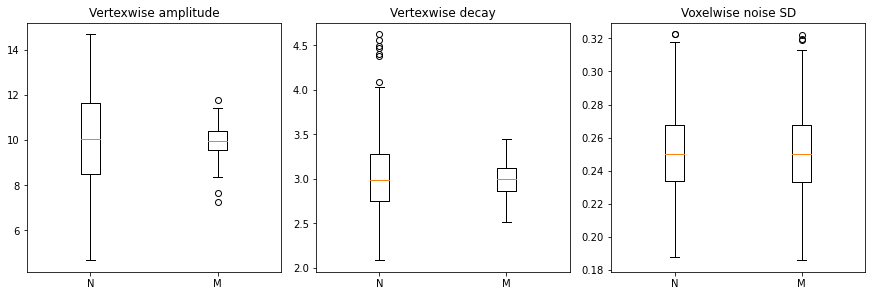

In [15]:
fig, axes = plt.subplots(1,3, constrained_layout=True)
fig.set_size_inches(12,4)
axes[0].set_title('Vertexwise amplitude')
axes[0].boxplot([amp_n, amp], labels=['N', 'M'])
axes[1].set_title('Vertexwise decay')
axes[1].boxplot([decay_n, decay], labels=['N', 'M'])
axes[2].set_title('Voxelwise noise SD')
axes[2].boxplot([noise, noise_n], labels=['N', 'M'])
plt.show()

**The following analysis is restricted to the M outputs only**

Plot vertex-wise parameter mean and variance against each other. There seems to be a small negative correlation in amplitude; no notable pattern in decay. 

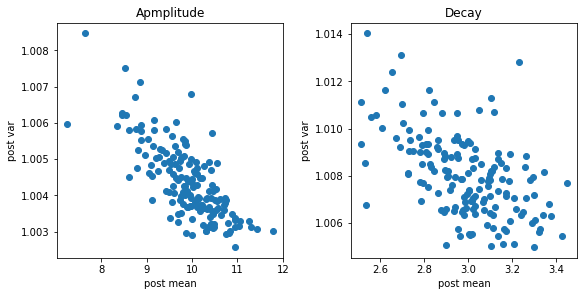

In [16]:
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp, amp_var)
axes[1].scatter(decay, decay_var)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('post var')

Plot vertexwise parameter means against each other. During the SVB run, the two model parameters were assumed to be independent of each other. A positive correlation is seen between amplitude and decay (why?). 

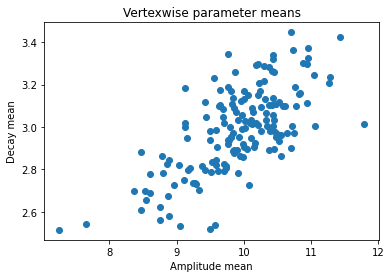

In [17]:
plt.scatter(amp, decay)
plt.title('Vertexwise parameter means')
plt.xlabel('Amplitude mean')
plt.ylabel('Decay mean')
plt.show()

Plot vertexwise parameter means against the PV of the voxel that the vertex associates to most strongly. This information is extracted from the projection matrix. Although a vertex can contribute to multiple voxels, we pick the one to which it contributes the most weight. One important aspect of surface SVB is that PVE are implicitly accounted for during the estimation process via the projection matrix. Hence, we should not see a corrrelation between voxel PV and estimated parameter means, and this does seem to be the case. 

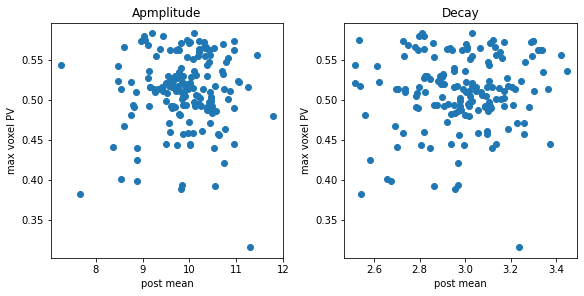

In [18]:
maxvox_inds = projector.surf2vol_matrix().argmax(0).A.flatten()
maxvox_pvs = projector.flat_pvs()[maxvox_inds,0]
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp, maxvox_pvs)
axes[1].scatter(decay, maxvox_pvs)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('max voxel PV')

Plot vertexwise parameter variances against the PV of the voxel that the vertex associates to most strongly. Based on the plot, it would seem that lower voxel PVs do not correlate with increased parameter uncertainty. 

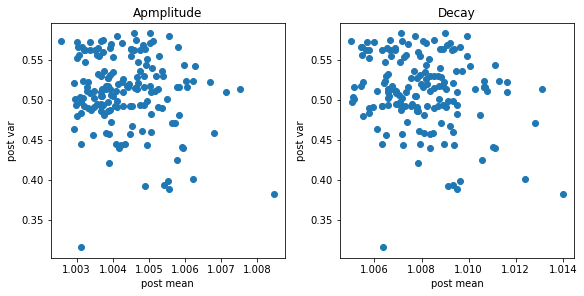

In [19]:
maxvox_inds = projector.surf2vol_matrix().argmax(0).A.flatten()
maxvox_pvs = projector.flat_pvs()[maxvox_inds,0]
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp_var, maxvox_pvs)
axes[1].scatter(decay_var, maxvox_pvs)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('post var')
plt.show()